# Burst DBS Helpers


In [2]:
# Importing Python and external packages


import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import scipy
from scipy import stats
from scipy import signal
from scipy.signal import spectrogram, butter, filtfilt, freqz
from scipy.signal.windows import hann

import seaborn as sns
import pingouin as pg
from itertools import combinations
#from statannotations.Annotator import Annotator

import openpyxl
from openpyxl import Workbook, load_workbook
# import xlrd
import pickle
import json
import csv
import fooof
from fooof.plts.spectra import plot_spectrum

#mne
import mne
from mne.time_frequency import tfr_morlet 

# xdf
import pyxdf
import pyxdftools
from pyxdftools import XdfData

import datetime

/var/folders/8d/3m_ljz890_j62q7hb7mpzdc40000gn/T/ipykernel_48895/2413707706.py:32: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  import fooof


In [3]:
%matplotlib qt

In [3]:
jennifer_user_path = os.getcwd()
while jennifer_user_path[-14:] != 'jenniferbehnke':
    jennifer_user_path = os.path.dirname(jennifer_user_path)

# directory to this Repository
project_path = os.path.join(jennifer_user_path, 'code', 'Patterned_stimulation_project', 'patterned_DBS')
sys.path.append(project_path)

os.chdir(project_path)

# patterned DBS
import src.patterned_DBS.beta_suppression_latency.patterned_dbs_pilot as pilot
import src.patterned_DBS.beta_suppression_latency.patterned_find_dbs_OFF_moment as find_dbs_OFF_moment

# utility functions
import src.patterned_DBS.utils.io as io
import src.patterned_DBS.utils.find_folders as find_folders
import src.patterned_DBS.utils.lfp_preprocessing as lfp_preprocessing
import src.patterned_DBS.utils.xdf_structure as xdf_structure

importlib.reload(pilot)
importlib.reload(find_dbs_OFF_moment)
importlib.reload(io)
importlib.reload(find_folders)
importlib.reload(lfp_preprocessing)
importlib.reload(xdf_structure)

<module 'src.patterned_DBS.utils.xdf_structure' from '/Users/jenniferbehnke/code/Patterned_stimulation_project/patterned_DBS/src/patterned_DBS/utils/xdf_structure.py'>

## Find paths

In [ ]:
burst_DBS_path = find_folders.get_onedrive_path_burst_dbs(
    folder="sub_lsl_data", sub="084"
)

In [129]:
data, header, burst_DBS_path = io.load_xdf_files(
    sub="084",
    stimulation="burst_on",
    medication="on", 
    task="updrs", 
    run="1",
)


Stream 2: Calculated effective sampling rate 564.1455 Hz is different from specified rate 10.0000 Hz.


## Randomization of patients to 
- continuous DBS first OR 
- burst DBS first

In [3]:
import pandas as pd
import numpy as np

# Set the seed for reproducibility
np.random.seed(123)

# Create a DataFrame with patient IDs
num_patients = 20
patients = pd.DataFrame({'PatientID': range(1, num_patients + 1)})

# Randomly assign patients to Group 1 or Group 2
patients['Group'] = np.random.choice(['continuous_first', 'burst_first'], size=num_patients)

# Display the result
print(patients)

    PatientID             Group
0           1  continuous_first
1           2       burst_first
2           3  continuous_first
3           4  continuous_first
4           5  continuous_first
5           6  continuous_first
6           7  continuous_first
7           8       burst_first
8           9       burst_first
9          10  continuous_first
10         11       burst_first
11         12       burst_first
12         13  continuous_first
13         14       burst_first
14         15  continuous_first
15         16       burst_first
16         17  continuous_first
17         18       burst_first
18         19       burst_first
19         20  continuous_first


## Load Percept data

### PyPerceive (BS Streaming)

In [37]:
from PerceiveImport.classes import main_class
py_perceive_data = main_class.PerceiveData(
        sub="084",
        incl_modalities=["streaming"],
        incl_session=["fu12m"],
        incl_condition=["m1s1"],
        incl_task=["updrs"],
        import_json=True,
        # warn_for_metaNaNs = True,
        # allow_NaNs_in_metadata = True,
    )

add run 1
add run 2


In [39]:
py_perceive_data.streaming.fu12m.m1s1.updrs.run1

runClass(sub='084', modality='streaming', session='fu12m', condition='m1s1', task='updrs', run=1, metaClass=MetadataClass(sub='084', incl_modalities=['streaming'], incl_session=['fu12m'], incl_condition=['m1s1'], incl_task=['updrs'], incl_contact=['RingR', 'SegmIntraR', 'SegmInterR', 'RingL', 'SegmIntraL', 'SegmInterL', 'Bip02', 'Bip13', 'Ring', 'Segments'], orig_meta_table=                                             report  \
0   Report_Json_Session_Report_20230912T105023.json   
1   Report_Json_Session_Report_20230912T105023.json   
2   Report_Json_Session_Report_20230912T105023.json   
3   Report_Json_Session_Report_20230912T105023.json   
4   Report_Json_Session_Report_20230912T105023.json   
5   Report_Json_Session_Report_20230912T105023.json   
6   Report_Json_Session_Report_20230912T105023.json   
7   Report_Json_Session_Report_20230912T105023.json   
8   Report_Json_Session_Report_20230912T105038.json   
9   Report_Json_Session_Report_20230912T105038.json   
10  Report_Json_Se

### Perceive

In [34]:
perceive_mne_data = io.load_perceive_file(
    sub="084",
    modality="streaming",
    task="updrs",
    medication="on",
    stimulation="StimOnB",
    run="1",
)

Creating RawArray with float64 data, n_channels=6, n_times=463563
    Range : 0 ... 463562 =      0.000 ...  1854.248 secs
Ready.


/Users/jenniferbehnke/code/Patterned_stimulation_project/patterned_DBS/src/patterned_DBS/utils/io.py:212: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = mne.io.read_raw_fieldtrip(file_path, info={}, data_name="data")
/Users/jenniferbehnke/code/Patterned_stimulation_project/patterned_DBS/src/patterned_DBS/utils/io.py:212: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(file_path, info={}, data_name="data")
/Users/jenniferbehnke/code/Patterned_stimulation_project/patterned_DBS/src/patterned_DBS/utils/io.py:212: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_13. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(file_path, info={}, data_name="data")
/Users/jenniferbehnke/code/Patterned_stimulation_project/patterned_DBS/src/patterned_DBS/utils/io.py:2

In [35]:
data = perceive_mne_data["data"]

In [37]:
plt.ion()
stim_data = data.get_data()[5]
plt.plot(stim_data)
plt.show()

## Load xdf files (LSL)

In [10]:
xdf_structured_data = xdf_structure.get_xdf_structure(
    sub="080",
    stimulation="StimOnA",
    medication="on", 
    task="updrs", 
    run="1",
)

Stream 1: Calculated effective sampling rate 810.8087 Hz is different from specified rate 10.0000 Hz.


In [11]:
xdf_structured_data["ultraleap_data"]

,left_pinky_tip_x,left_pinky_tip_y,left_pinky_tip_z,left_ring_tip_x,left_ring_tip_y,left_ring_tip_z,left_middle_tip_x,left_middle_tip_y,left_middle_tip_z,left_index_tip_x,...,right_index_tip_x,right_index_tip_y,right_index_tip_z,right_thumb_tip_x,right_thumb_tip_y,right_thumb_tip_z,right_palm_x,right_palm_y,right_palm_z,timestamps
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.135348e+06
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.135348e+06
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.135348e+06
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.135348e+06
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.135348e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.136163e+06
660916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.136163e+06
660917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.136163e+06
660918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.136163e+06


In [60]:
xdf_structured_data["SAGA_data"]

,BIP 01,BIP 02,BIP 03,X,Y,Z,X,Y,Z,ISO aux,ISO aux,AUX 3-3,TRIGGERS,STATUS,COUNTER,timestamps
0,7274.714844,0.0,-16152.843750,-0.945969,-0.302612,-0.195502,-0.740117,0.448036,-0.389956,0.036062,2.301259,0.0,255.0,1026.0,5319607.0,3.213445e+06
1,7286.459961,0.0,-16155.963867,-0.946836,-0.298856,-0.200600,-0.744608,0.451264,-0.406666,0.036202,2.301387,0.0,255.0,1026.0,5319608.0,3.213445e+06
2,7310.354004,0.0,-16163.928711,-0.942490,-0.298196,-0.194661,-0.748400,0.449012,-0.402954,0.036330,2.301253,0.0,255.0,1026.0,5319609.0,3.213445e+06
3,7334.064941,0.0,-16173.197266,-0.936626,-0.295790,-0.193819,-0.754130,0.449975,-0.396568,0.036203,2.301416,0.0,255.0,1026.0,5319610.0,3.213445e+06
4,7359.409180,0.0,-16176.572266,-0.930521,-0.293222,-0.204011,-0.753432,0.455545,-0.400360,0.036138,2.301471,0.0,255.0,1026.0,5319611.0,3.213445e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530105,134300.250000,0.0,0.000000,-0.104918,-0.403556,1.022471,-0.066876,0.262449,-0.868880,0.035858,2.289343,0.0,255.0,1026.0,7849712.0,3.214077e+06
2530106,134310.906250,0.0,0.000000,-0.101764,-0.403786,1.015315,-0.065743,0.262652,-0.865484,0.035840,2.289127,0.0,255.0,1026.0,7849713.0,3.214077e+06
2530107,134317.812500,0.0,0.000000,-0.099917,-0.408034,1.017309,-0.065113,0.260809,-0.858220,0.036197,2.289640,0.0,255.0,1026.0,7849714.0,3.214077e+06
2530108,134325.984375,0.0,0.000000,-0.101601,-0.407604,1.024384,-0.062606,0.257849,-0.857595,0.036281,2.289829,0.0,255.0,1026.0,7849715.0,3.214077e+06


In [120]:
path = xdf_structured_data["xdf_path"]


streams = XdfData(path).resolve_streams()
streams

,name,type,source_id,created_at,uid,session_id,hostname,channel_count,channel_format,nominal_srate
stream_id,,,,,,,,,,
1,SAGA,EEG,tmsi-0,3143389.350878200,677fecf0-9b30-4a82-b930-595c28cc8a87,default,DESKTOP-B9S1LTJ,15,float32,4000.0
2,Unity.UltraleapTracking,Unity.StreamType,None,3143290.847800500,76da819a-c784-4643-86eb-487e1bd90e51,default,DESKTOP-B9S1LTJ,36,float32,10.0


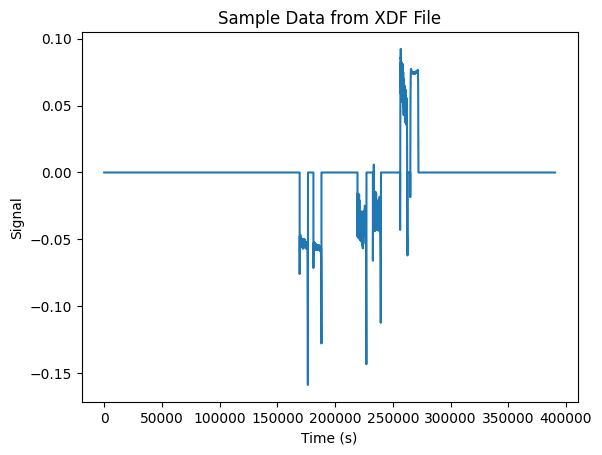

In [168]:
# Example: Plot the first few samples of the first stream
plt.plot(channel_2)
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Sample Data from XDF File')
plt.show()

## Load metadata

In [8]:
metadata = io.load_metadata_excel(
    sub="084",
    sheet_name="stimulation_parameters",    
)

Excel file loaded:  metadata_084.xlsx 
loaded from:  /Users/jenniferbehnke/OneDrive - Charité - Universitätsmedizin Berlin/Burst_DBS_project - AG Bewegungsstörungen/data/sub-084


In [9]:
metadata

,sub_id,hemisphere,loca_contacts_stn_center,active_contacts,sum_active_contacts_impedance,clinical_current,clinical_pulsewidth,cinical_frequency,clinical_teed_J_per_0.2s,burst_current,burst_pulsewidth,burst_frequency,burst_teed_J_per_0.2s,calculated_burst_current_mA
0,84,left,NaN,1,6863,2.6,60,130,0.000072,2.2,60,180,0.000072,2.209575
1,84,right,NaN,2,6863,2.3,60,130,0.000057,1.9,60,180,0.000054,1.954624


In [15]:
left_stim_contact = metadata.loc[metadata["hemisphere"] == "left"]
left_stim_contact = left_stim_contact.active_contacts.values[0]
str(left_stim_contact)

'1'